In [1]:
# ref: 

# https://alexioannides.com/2018/11/07/bayesian-regression-in-pymc3-using-mcmc-variational-inference/
# https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html

# http://stronginference.com/pymc3-release.html
# https://docs.pymc.io/notebooks/getting_started.html

# https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501

In [2]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
np.random.seed(23)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [3]:
# Building dataset

def build_toy_dataset(N_points=50, noise_std=0.1):
    x = np.linspace(-3, 3, num=N_points)
    y = np.cos(x) + np.random.normal(0, noise_std, size=N_points)
    x = x.astype(np.float64).reshape((N_points, 1))
    y = y.astype(np.float64)[:,None]
    return x, y

# simulate a toy dataset of observations with a cosine relationship.
N_points = 100  # number of data points

X_data,y_data = build_toy_dataset(N_points)
print (np.shape(X_data),np.shape(y_data))

(100, 1) (100, 1)


In [4]:
# Shuffling dataset
from sklearn.utils import shuffle

X_data_shuff,y_data_shuff = shuffle(X_data,y_data,random_state=23)
print (np.shape(X_data_shuff),np.shape(y_data_shuff))

(100, 1) (100, 1)


In [5]:
# Splitting dataset

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data_shuff, y_data_shuff, test_size=0.2, random_state=23)
print (np.shape(X_train), np.shape(y_train))
print (np.shape(X_test), np.shape(y_test))

(80, 1) (80, 1)
(20, 1) (20, 1)


In [6]:
# Building pymc model

n_hidden = 3

# Initialize random weights between each layer
init_w_1 = np.random.randn(X_train.shape[1], n_hidden).astype(floatX)
init_w_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_w_out = np.random.randn(n_hidden,1).astype(floatX)

init_b_1 = np.random.randn(n_hidden).astype(floatX)
init_b_2 = np.random.randn(n_hidden).astype(floatX)
init_b_out = np.random.randn(1).astype(floatX)


def DNN(x_tensor, weights_in_1, bias_in_1, weights_1_2, bias_1_2, weights_2_out, bias_2_out):
    act_1 = pm.math.tanh(pm.math.dot(x_tensor,weights_in_1)+bias_in_1)
    act_2 = pm.math.tanh(pm.math.dot(act_1,weights_1_2)+bias_1_2)
    act_out = pm.math.dot(act_2,weights_2_out)+bias_2_out
    return act_out

with pm.Model() as neural_network:
    # Trick: Turning inputs and outputs into shared variables 
    # It's still the same thing, but we can later change the values of the shared variable
    # (to switch in the test-data later) and pymc3 will just use the new data.
    # Kind-of like a pointer we can redirect.
    # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
    y_tensor = theano.shared(y_train)
    x_tensor = theano.shared(X_train)

    #PRIOR
    # Weights and biases from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                             shape=(X_train.shape[1], n_hidden),
                             testval=init_w_1)
    
    bias_in_1 = pm.Normal('b_in_1', 0, sigma=1,
                             shape=(n_hidden),
                             testval=init_b_1)

    # Weights and biases from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                            shape=(n_hidden, n_hidden),
                            testval=init_w_2)
  
    bias_1_2 = pm.Normal('b_1_2', 0, sigma=1,
                             shape=(n_hidden),
                             testval=init_b_2)

    # Weights and biases from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                              shape=(n_hidden,1),
                              testval=init_w_out)

    bias_2_out = pm.Normal('b_2_out', 0, sigma=1,
                             shape=(1),
                             testval=init_b_out)
        
    # Build neural-network using activation function
    act_out = DNN(x_tensor, weights_in_1, bias_in_1, weights_1_2, bias_1_2, weights_2_out, bias_2_out)

    # LIKELIHOOD
    out = pm.Normal('out', mu=act_out, sigma=0.1, observed=y_tensor)


(5, 100)


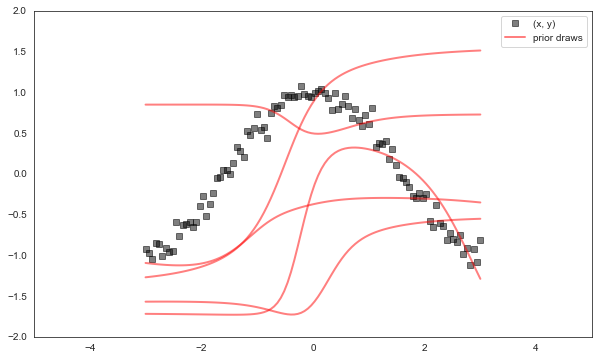

In [7]:
#checking prior draws

with neural_network:
    preds =[DNN(X_data, weights_in_1.random(), bias_in_1.random(), weights_1_2.random(), bias_1_2.random(), weights_2_out.random(), bias_2_out.random()).eval()
     for _ in range(5)]
    preds = np.asarray(preds)
    outputs = preds.reshape(preds.shape[0],preds.shape[1])
    print(np.shape(outputs))

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(X_data, y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
    ax.plot(X_data, outputs[0].T, 'r', lw=2, alpha=0.5, label='prior draws')
    ax.plot(X_data, outputs[1:].T, 'r', lw=2, alpha=0.5)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-2, 2])
    ax.legend()
    plt.show()

In [8]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [9]:
# Carrying out ADVI

with neural_network:
    advi_fit = pm.fit(n=60000, method=pm.ADVI())

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 10.764: 100%|██████████| 60000/60000 [00:28<00:00, 2104.42it/s] 
Finished [100%]: Average Loss = 10.733


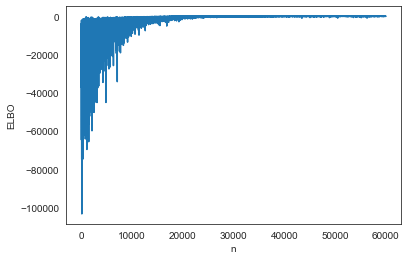

In [10]:
advi_elbo = pd.DataFrame(
    {'ELBO': -(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

## Drawing samples

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNIN

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1154a4cf8>],
      dtype=object)

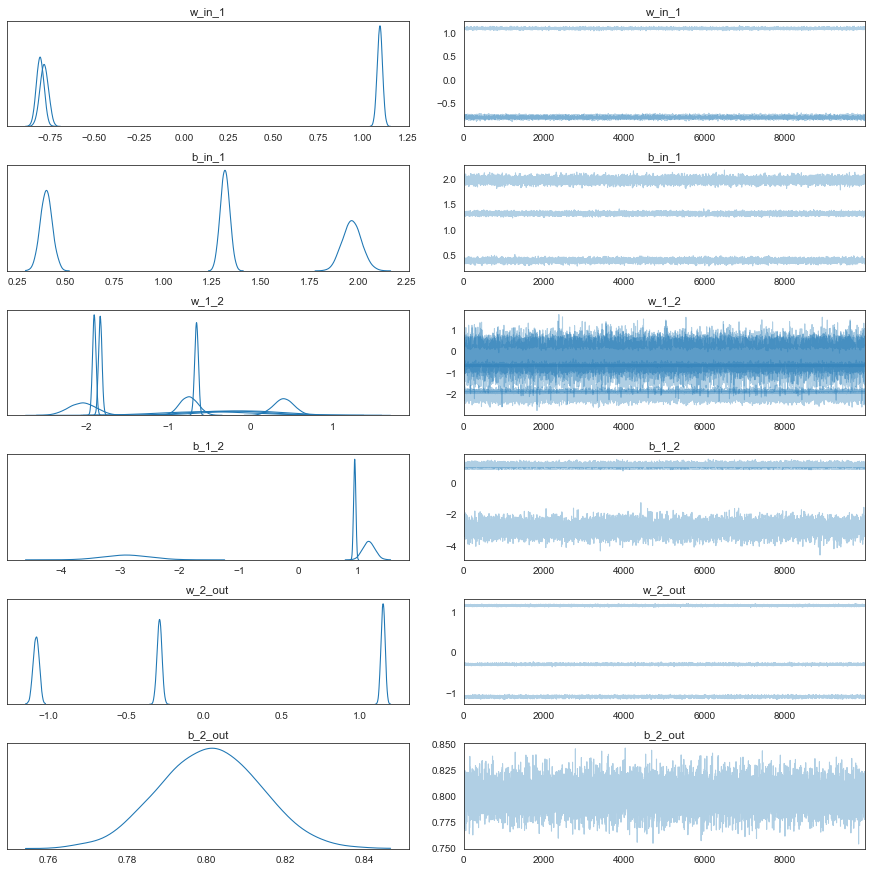

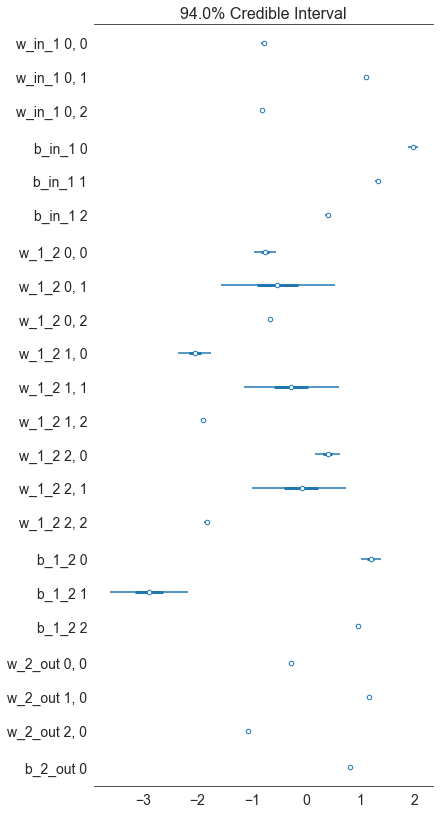

In [11]:
trace = advi_fit.sample(draws=10000)
pm.traceplot(trace)
pm.summary(trace)
pm.forestplot(trace)

## Checking

(5, 100)


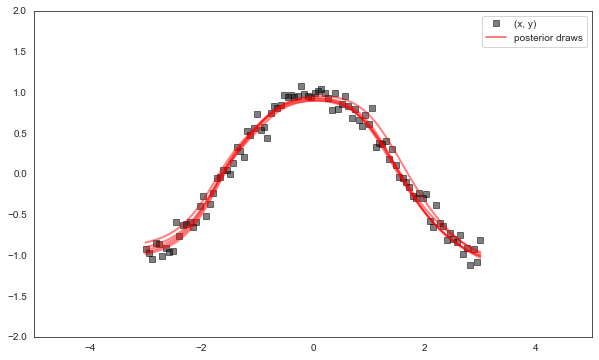

In [12]:
# checking posterior draws

preds =[DNN(X_data, trace['w_in_1'][i], trace['b_in_1'][i], trace['w_1_2'][i], trace['b_1_2'][i], trace['w_2_out'][i], trace['b_2_out'][i]).eval()
 for i in range(5)]
preds = np.asarray(preds)
outputs = preds.reshape(preds.shape[0],preds.shape[1])
print(np.shape(outputs))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(X_data, y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
ax.plot(X_data, outputs[0].T, 'r', lw=2, alpha=0.5, label='posterior draws')
ax.plot(X_data, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()

## Testing

In [13]:
# testing on whole data for now instead of test data
y_tensor.set_value(y_data)
x_tensor.set_value(X_data)

In [14]:
posterior_preds = pm.sample_posterior_predictive(trace, 1000, neural_network)
mean_prediction = np.mean(posterior_preds['out'], axis=0)
stddev_prediction = np.std(posterior_preds['out'], axis=0)
print (posterior_preds['out'].shape)

100%|██████████| 1000/1000 [00:10<00:00, 96.25it/s]

(1000, 100, 1)


        ADVI    actual  error_ADVI
0  -0.936710 -0.923294   -0.013417
1  -0.932620 -0.977046    0.044426
2  -0.917229 -1.043427    0.126198
3  -0.908233 -0.853294   -0.054939
4  -0.897869 -0.857000   -0.040869
..       ...       ...         ...
95 -0.881244 -0.907955    0.026711
96 -0.898088 -1.120482    0.222394
97 -0.924464 -0.919539   -0.004925
98 -0.941021 -1.088164    0.147143
99 -0.965300 -0.807655   -0.157645

[100 rows x 3 columns]


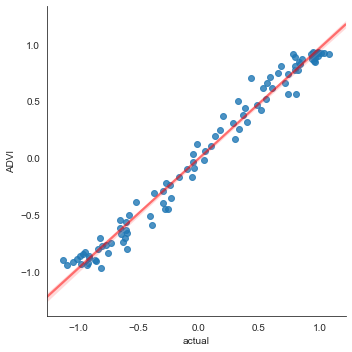

In [15]:
prediction_data = pd.DataFrame(
    {'ADVI': mean_prediction.flatten(), 
     'actual': y_data.flatten(),
     'error_ADVI': ( mean_prediction - y_data).flatten()})

print (prediction_data)

_ = sns.lmplot(y='ADVI', x='actual', data=prediction_data,
               line_kws={'color': 'red', 'alpha': 0.5})

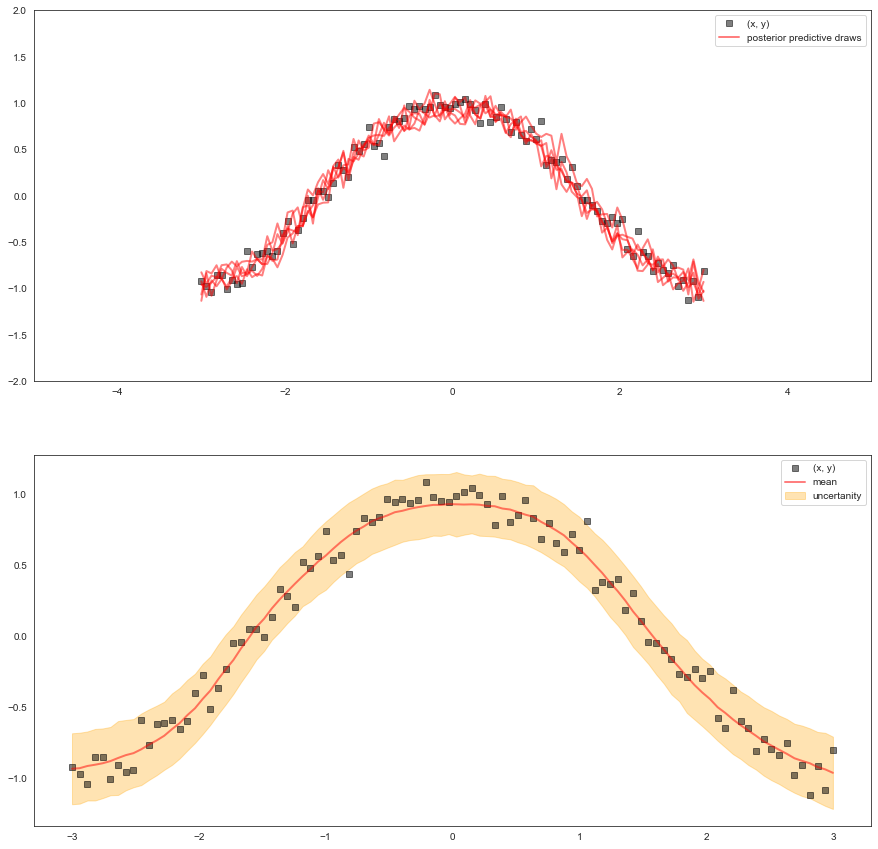

In [16]:
fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(211)
ax1.plot(X_data, y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
ax1.plot(X_data, posterior_preds['out'][0] ,'r', lw=2, alpha=0.5, label='posterior predictive draws')
ax1.plot(X_data, posterior_preds['out'][1:5].reshape(4,X_data.shape[0]).T, 'r', lw=2, alpha=0.5)
ax1.set_xlim([-5, 5])
ax1.set_ylim([-2, 2])
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(X_data, y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
ax2.plot(X_data, mean_prediction , 'r', lw=2, alpha=0.5, label='mean')
ax2.fill_between( X_data.ravel(), (mean_prediction-2*stddev_prediction).ravel(), (mean_prediction+2*stddev_prediction).ravel(), alpha = 0.3, color = 'orange',label='uncertanity')
ax2.legend()

plt.show()

In [17]:
RMSE = np.sqrt(np.mean(prediction_data.error_ADVI ** 2))

print(f'RMSE for ADVI predictions = {RMSE:.3f}')

RMSE for ADVI predictions = 0.098


(10000, 1, 3)


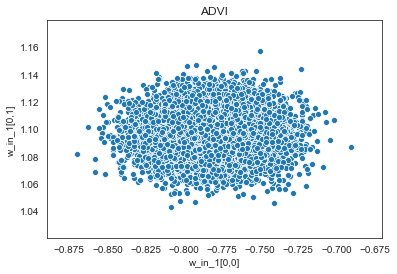

In [18]:
print(trace.get_values('w_in_1').shape)

param_samples_ADVI = pd.DataFrame(
    {'w_in_1[0,0]': trace.get_values('w_in_1').reshape(trace.get_values('w_in_1').shape[0],trace.get_values('w_in_1').shape[2])[:,0], 
     'w_in_1[0,1]': trace.get_values('w_in_1').reshape(trace.get_values('w_in_1').shape[0],trace.get_values('w_in_1').shape[2])[:,1]})

_ = sns.scatterplot(x='w_in_1[0,0]', y='w_in_1[0,1]', data=param_samples_ADVI).set_title('ADVI')